In [1]:
print("Bismillah Hirrahamaa Nirraheem")

Bismillah Hirrahamaa Nirraheem


In [128]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import sys
pio.templates['mod'] = go.layout.Template(layout=dict(font=dict(family="Fira Code",size=20)))
pio.templates.default = "plotly_dark+mod"
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,roc_curve,accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from missingno import matrix
from zipfile import ZipFile
from IPython.display import clear_output
import shutil
from IPython.display import clear_output
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/Drive')
    !pip install miceforest
    import miceforest as mf
else:
    import miceforest as mf

clear_output()

In [3]:
if "google.colab" in sys.modules:
    !mkdir ~/.kaggle
    shutil.copy2('/content/Drive/MyDrive/kaggle.json','/root/.kaggle')
    !kaggle competitions download -c spaceship-titanic
    path = '/content/'
else:
    !kaggle competitions download -c spaceship-titanic
    path = '/home/sohail/Downloads/'

100%|█████████████████████████████████████████| 299k/299k [00:01<00:00, 292kB/s]
100%|█████████████████████████████████████████| 299k/299k [00:01<00:00, 292kB/s]


In [4]:
with ZipFile(file=path+'spaceship-titanic.zip',mode="r") as file:
    file.extractall(path+'spaceship-titanic-folder')

In [5]:
train = pd.read_csv(path+'spaceship-titanic-folder/train.csv')
test = pd.read_csv(path+'spaceship-titanic-folder/test.csv')
sample = pd.read_csv(path+'spaceship-titanic-folder/sample_submission.csv')

In [6]:
total = train.copy()

# Table
<font size=4>

|SI.No|Name of Column|Description|
|-----|--------------|-----------|
|1|PassengerId|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.|
|2|HomePlanet|The planet the passenger departed from, typically their planet of permanent residence|
|3|CryoSleep|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins|
|4|Cabin|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.|
|5|Destination|The planet the passenger will be debarking to|
|6|Age|The age of the passenger|
|7|VIP|Whether the passenger has paid for special VIP service during the voyage|
|8|RoomService, FoodCourt, ShoppingMall, Spa, VRDeck|Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities|
|9|Name|The first and last names of the passenger|
|10|Transported| Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict|

</font>

# Preprocessing

## Filling Nan's

as you can see there are quite a bit of Null values which need to be filled, we can apply some stratergies as we will see below

In [7]:
def preprocess_1(data:pd.DataFrame):
    df = data.copy()
    df[['CryoSleep','VIP']] = df[['CryoSleep','VIP']].astype(np.float32)
    df[['Group','Within']] = df.PassengerId.str.split('_',expand=True).astype(np.float32)
    df = df[df.columns[-2:].to_list()+df.columns[1:-2].to_list()]
    df[['deck','num','side']] = df.Cabin.str.split('/',expand=True)
    df = df[df.columns[:4].to_list() + df.columns[-3:].to_list() + df.columns[5:-3].to_list()]
    df['num'] = df['num'].astype(np.float32)
    df[['First','Last']] = df.Name.str.split(' ',expand=True)
    df = df[df.columns[:2].to_list() + df.columns[-2:].to_list() + df.columns[2:-2].to_list()]
    df.drop('Name',axis=1,inplace=True)
    return df.infer_objects()

In [8]:
total_train = preprocess_1(train)
total_test = preprocess_1(test)

In [9]:
total_df = pd.concat([total_train,total_test])
y_total = total_df[['Transported']].astype(np.float32).dropna()
total_df.drop('Transported',axis=1,inplace=True)
total_df.reset_index(inplace=True,drop=True)

In [10]:
num_cols = ['Group','Within','num','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cat_cols = ['HomePlanet','CryoSleep','deck','side','Destination','VIP']
last_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
all_cats = []
for col in cat_cols:
    all_cats += total_df[col].dropna().unique().tolist()

- Group, Within don't have any null values as they are from PassengerId column<br>
<br>
<font size=8>
Strategy :
</font>

- The strategy is to first fill null values according to the first and last names of the passengers as they are the closest relations for null values
- The First,Last columns also have null values so for the columns with null we will impute the most recurrent in terms of categorical column
- Then Look for the best predictors for single na values and impute those
- The impute the doubly filled columns with clustering/normal imputation


Missing Values

<Axes: >

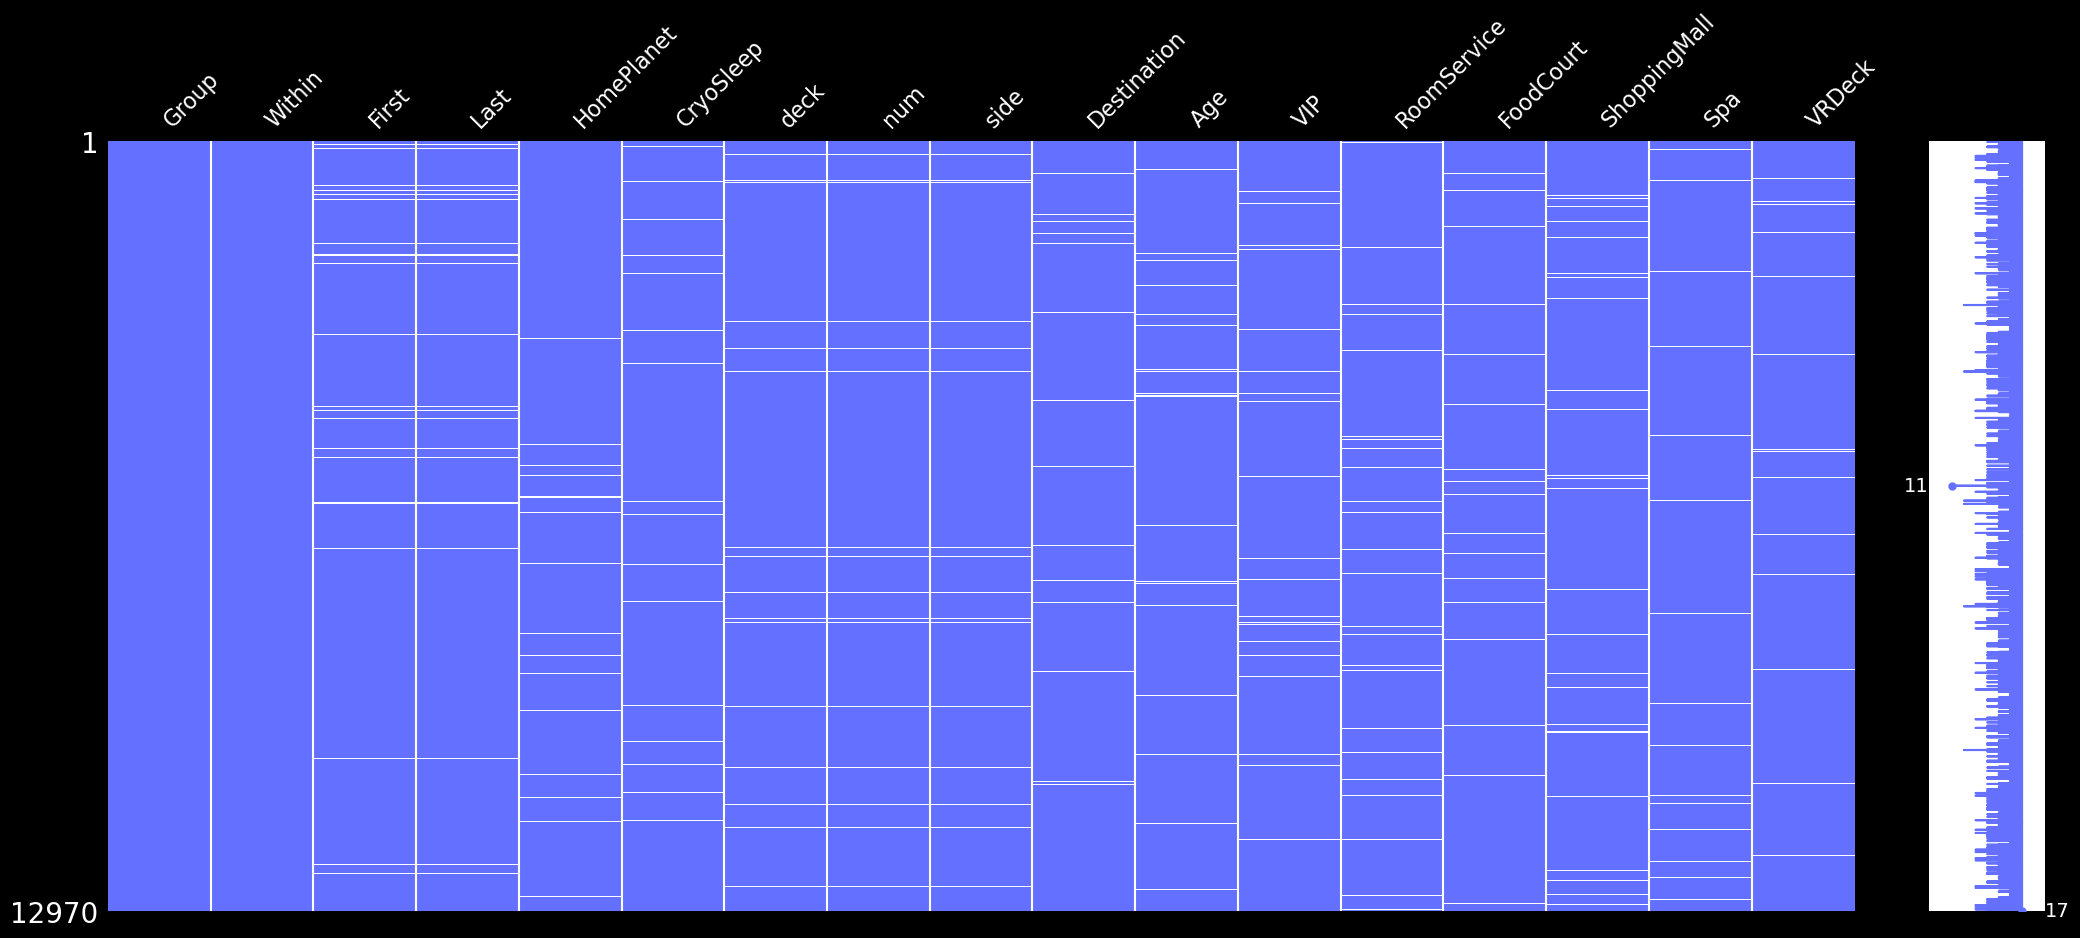

In [11]:
plt.style.use('dark_background')
matrix(total_df,color=(99/250,110/250,1))

In [12]:
total_no_na = total_df.dropna()
total_na = total_df[total_df.isna().any(axis=1)]
print("No NaN shape",total_no_na.shape)
print("any NaN shape",total_na.shape)

No NaN shape (9887, 17)
any NaN shape (3083, 17)


In [13]:
temp_df = pd.get_dummies(total_no_na,columns=['HomePlanet','deck','side','Destination'],prefix="",prefix_sep="",dtype=np.float32)
temp_df = temp_df.loc[:,temp_df.columns.difference(['First','Last'])].corr(method='spearman')
np.fill_diagonal(temp_df.to_numpy(),0)
px.imshow(temp_df,height=1000,width=1800).update_xaxes(tickangle=30)

filling the values with same First Name

before filling 

In [14]:
print("before filling :")
print("no of single vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 1)].shape[0])
print("no of double vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 2)].shape[0])
print("no of triple vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 3)].shape[0])

before filling :
no of single vacant rows : 2274
no of double vacant rows : 441
no of triple vacant rows : 303


In [15]:
for ind in total_na.index:
    col = total_na.columns[total_na.loc[ind].isna()]
    temp_df = total_no_na.query(f"Group == {total_na.loc[ind,'Group']} and Last == '{total_na.loc[ind,'Last']}'")
    if temp_df.shape[0] != 0:
        total_df.loc[ind,col] = temp_df.loc[temp_df.index[0],col]

In [16]:
print("after filling :")
print("no of single vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 1)].shape[0])
print("no of double vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 2)].shape[0])
print("no of triple vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 3)].shape[0])

after filling :
no of single vacant rows : 1466
no of double vacant rows : 364
no of triple vacant rows : 214


In [17]:
total_no_na = total_df.dropna()
total_na = total_df[total_df.isna().any(axis=1)]
print("No NaN shape",total_no_na.shape)
print("any NaN shape",total_na.shape)

No NaN shape (10880, 17)
any NaN shape (2090, 17)


In [18]:
temp_df = pd.get_dummies(total_no_na,columns=['HomePlanet','deck','side','Destination'],prefix="",prefix_sep="",dtype=np.float32)
temp_df = temp_df.drop(['First','Last'],axis=1).corr(method='spearman')
np.fill_diagonal(temp_df.to_numpy(),0)
px.imshow(temp_df,height=1000,width=1800).update_xaxes(tickangle=30)

In [77]:
total_df.head(2)

,Group,Within,First,Last,HomePlanet,CryoSleep,deck,num,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,1.0,1.0,Maham,Ofracculy,Europa,0.0,B,0.0,P,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,Juanna,Vines,Earth,0.0,F,0.0,S,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0


In [78]:
temp_df = total_df.drop(['First','Last'],axis=1)
# temp_df = pd.get_dummies(temp_df,columns=['HomePlanet','side','deck','Destination'],prefix_sep="",prefix="",dtype=np.float32)
ord_enc = OrdinalEncoder()
ord_enc.set_output(transform="pandas")
temp_df = pd.concat([temp_df[['Group','Within','CryoSleep','VIP','num','Age']+last_cols],ord_enc.fit_transform(temp_df[['HomePlanet','deck','side','Destination']])],axis=1)
kds = mf.ImputationKernel(temp_df,random_state=55,save_all_iterations=True,datasets=5)
kds.mice(10,n_estimators=100,max_depth=8,device="gpu")

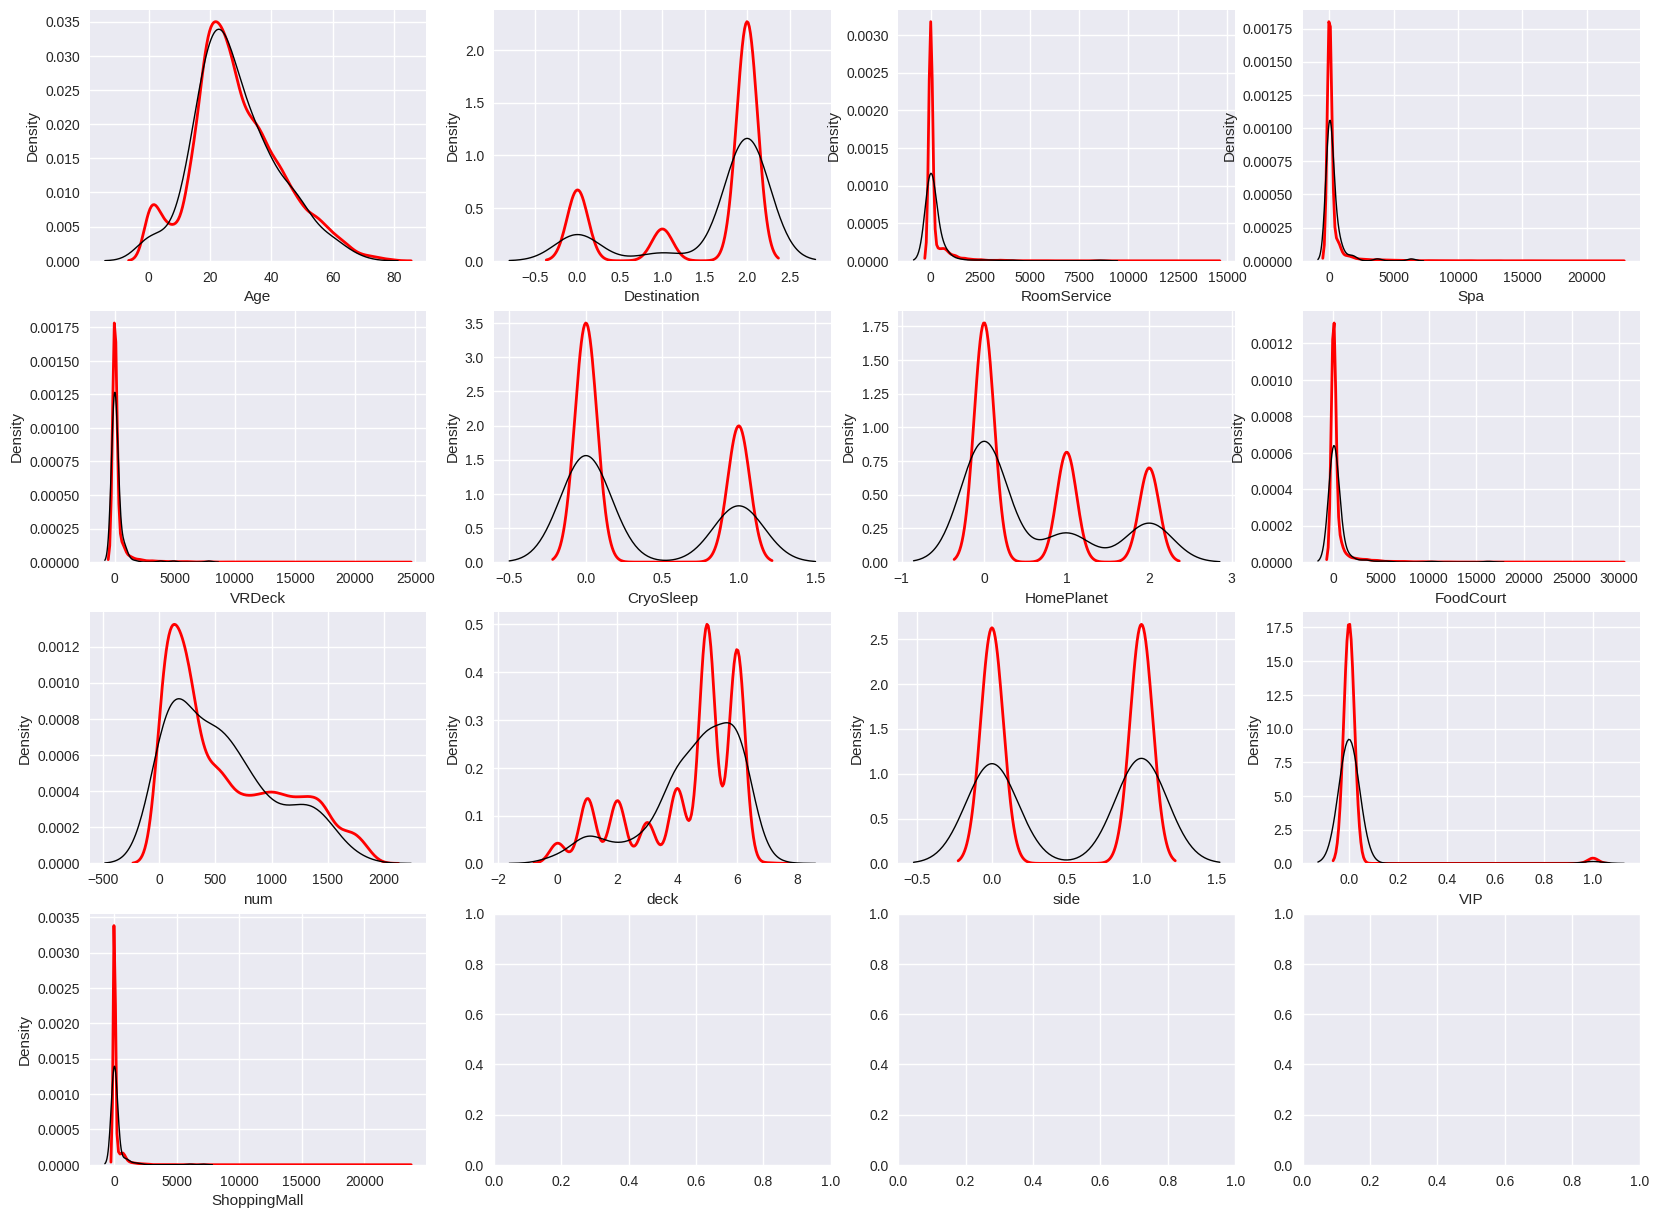

In [84]:
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (20,15)
kds.plot_imputed_distributions()

In [109]:
new_data = kds.complete_data(3)
new_data = pd.get_dummies(new_data,columns=['HomePlanet','deck','side','Destination'],prefix_sep="",prefix="",dtype=np.float32)
new_data.head()

,Group,Within,CryoSleep,VIP,num,Age,RoomService,FoodCourt,ShoppingMall,Spa,...,3.0,4.0,5.0,6.0,7.0,0.0,1.0,0.0,1.0,2.0
0,1.0,1.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2.0,1.0,0.0,0.0,0.0,24.0,109.0,9.0,25.0,549.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3.0,1.0,0.0,1.0,0.0,58.0,43.0,3576.0,0.0,6715.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,3.0,2.0,0.0,0.0,0.0,33.0,0.0,1283.0,371.0,3329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4.0,1.0,0.0,0.0,1.0,16.0,303.0,70.0,151.0,565.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [111]:
stan = StandardScaler()
stan.set_output(transform='pandas')
new_data[num_cols] = stan.fit_transform(new_data[num_cols])
train_set = new_data.loc[:8692].copy()
test_set = new_data.loc[8693:].copy()
y_arr = y_total.to_numpy().ravel()
X = train_set.to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y_arr,stratify=y_arr,shuffle=True,random_state=55)
grad = GradientBoostingClassifier(n_estimators=100,max_depth=6)
grad.fit(X_train,y_train)
print(grad.score(X_test,y_test))

0.8247470101195952


In [130]:
xgb_clf = xgb.XGBClassifier(n_jobs=-1)
params = {
    "n_estimators":np.arange(50,500,50),
    "max_depth":np.arange(3,16,2),
    "learning_rate":np.logspace(-4,-1,4)   
}
strat = StratifiedShuffleSplit(2,test_size=0.2,random_state=56)
grid = GridSearchCV(xgb_clf,param_grid=params,cv=strat,n_jobs=-1,scoring="accuracy")
grid.fit(X,y_arr)
print(grid.best_score_)
print(grid.best_params_)

0.8039102932719955
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}


In [133]:
y_pred = grad.predict(test_set.to_numpy())

In [140]:
sample['Transported'] = y_pred.astype(np.bool_)

In [22]:
class TotalTransform(BaseEstimator,TransformerMixin):

    def __init__(self,train=True):
        self.train = train

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        pass

# Rough Work

In [23]:
# check for corr() coefficient
# arr1 = np.random.randint(20,40,30)
# arr2 = np.random.randint(1,20,30)
# temp_df = pd.DataFrame(np.hstack([arr1,arr2]),columns=["num"])
# temp_df.loc[:30,'choice'] = 0
# temp_df.loc[30:,'choice'] = 1
# temp_df.corr()
# check for same deck,num,side in total_na
# num = 2
# total_no_na.query(f"Last == '{total_na.query('deck != deck').Last.iloc[num]}' and Group == {total_na.query('deck != deck').Group.iloc[num]}")